In [30]:
# --- Imports ---
import sctm # Make sure you pip install sctm
import anndata as ad
import scanpy as sc
import squidpy as sq
import seaborn as sns
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Import for plotting control and potentially saving
import matplotlib.ticker as mticker # Import ticker (though not directly used in final plot)
import traceback
from scipy.sparse import issparse # For checking sparse matrices

In [3]:
adata = sc.read_h5ad(
    "./merged_spatial_h5ad/BASS_clustered_filtered_merged_spatial_rois_RAW.h5ad"
)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 4991 × 18993
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'geometry_wkt', 'area', 'tissue_section_id', 'sample_id', 'BASS_clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
adata.layers["counts"] = adata.X.copy()

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_genes(adata, min_cells=10)  # 至少出现在10个细胞中
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
sc.pp.normalize_total(adata, target_sum=1e4)  # 标准化
sc.pp.log1p(adata)  # 对数转换

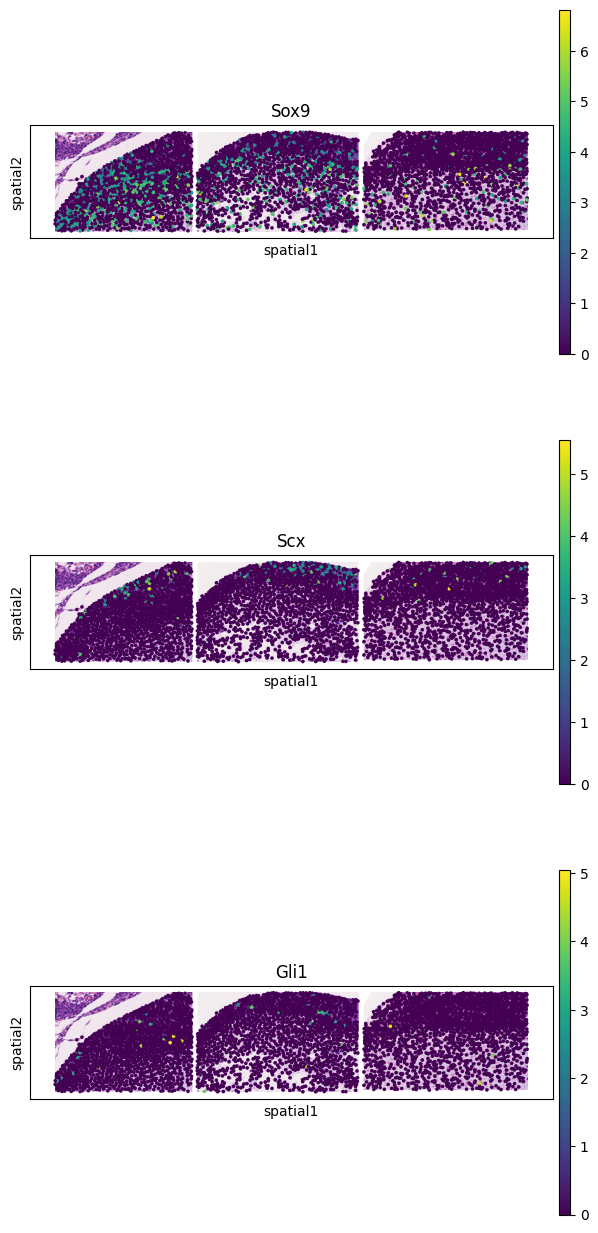

In [35]:
cmap = sns.blend_palette(["#e8e8e8", "#8B008B"], as_cmap=True)
sc.pl.spatial(adata, 
              color=['Sox9','Scx','Gli1'], 
              size = 2, 
              ncols=1,
              #cmap = cmap,
              sort_order='descending', 
              # figsize=(10, 5),
              save = 'genes spatial plots.pdf')

In [ ]:
# 检查数据矩阵
if np.isnan(adata.X.data).any():
    print("发现 NaN 值，需清理数据！")
    adata.X = adata.X.filled(0)  # 填充零或其他合理值

In [6]:
sq.gr.spatial_neighbors(adata)

In [7]:
adata.obs['sample_id']

e14_ID_30818    e14
e14_ID_30820    e14
e14_ID_30829    e14
e14_ID_30831    e14
e14_ID_30832    e14
               ... 
e16_ID_60488    e16
e16_ID_60494    e16
e16_ID_60495    e16
e16_ID_60500    e16
e16_ID_60501    e16
Name: sample_id, Length: 4991, dtype: category
Categories (3, object): ['e14', 'e15', 'e16']

In [ ]:
sctm.seed.seed_everything(5)
# Only hvgs and fit a total of 20 topics
n_topics = 6

model = sctm.stamp.STAMP(
    adata,
    layer="counts",
    n_topics = n_topics,
    gene_likelihood = "nb"
)

# uses gpu by default to use cpu use device="cpu"
model.train(learning_rate = 0.001, min_epochs = 100)

In [9]:
## !!!!!!!!!!!!!!! time series

import torch
import sctm
import scanpy as sc
import numpy as np
import pandas as pd

# --- SOLUTION 1 START ---
# Set the default dtype for PyTorch tensors to float32
torch.set_default_dtype(torch.float32)

# Ensure the numerical time column is created (from previous step)
# Make sure it's float32 *before* model initialization
try:
    # Ensure the time column is float32
    adata.obs['time_numeric'] = adata.obs['sample_id'].str.replace('e', '').astype('float32')
    print("Created time_numeric column with dtype:", adata.obs['time_numeric'].dtype)
except AttributeError:
     print("Warning: Could not automatically convert 'sample_id'. Trying direct conversion or manual mapping.")
     time_map = {'e14': 14.0, 'e15': 15.0, 'e16': 16.0}
     # Ensure the mapped values are float32
     adata.obs['time_numeric'] = adata.obs['sample_id'].map(time_map).astype('float32')
     print("Created time_numeric column via mapping with dtype:", adata.obs['time_numeric'].dtype)

# --- Rest of your code ---
sctm.seed.seed_everything(5)
n_topics = 6

# The STAMP model will now likely use float32 internally due to the default setting
model = sctm.stamp.STAMP(
    adata,
    layer="counts",
    time_covariate_keys="time_numeric", # Use the float32 numeric column
    n_topics=n_topics,
    gene_likelihood="nb"
)

# uses gpu by default to use cpu use device="cpu"
# Explicitly set device='cpu' if you don't have/want GPU
device_to_use = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device_to_use}")

try:
    model.train(learning_rate=0.001, min_epochs=100, device=device_to_use) # Pass device if needed
except Exception as e:
    print(f"An error occurred during training: {e}")
    import traceback
    traceback.print_exc()

Created time_numeric column with dtype: float32
Computing background frequencies
Computing background frequencies
Computing background frequencies
Using device: cuda


  0%|                                                                                       | 0/800 [00:00<?, ?it/s]/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/pyro/primitives.py:478: UserWarning: encoder.norm_topic.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/pyro/primitives.py:478: UserWarning: encoder.norm_topic.1.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/pyro/primitives.py:478: UserWarning: encoder.norm_topic.2.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
Epoch Loss:647.999:  29%|████████████████▌                             

Early Stopping
Model training started successfully.


In [10]:
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

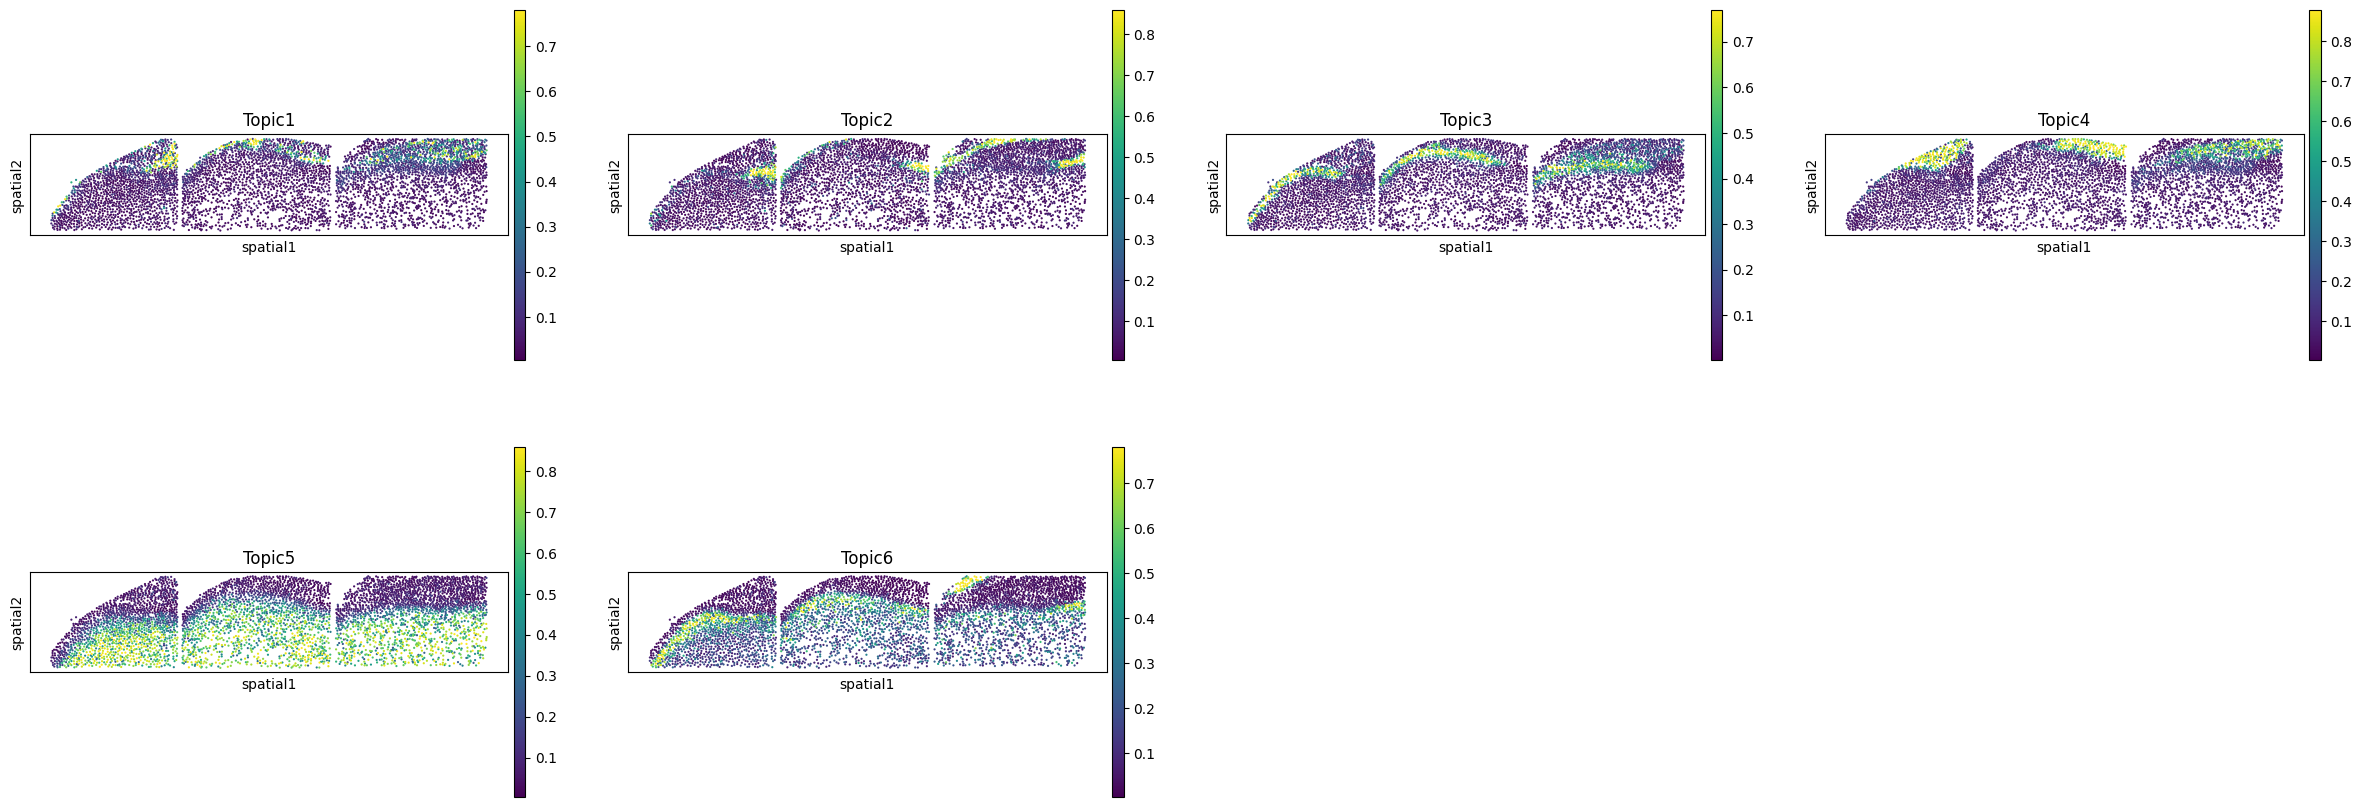

In [12]:
sctm.pl.spatial(adata, color=topic_prop.columns, size = 10, vmax="p99")

In [11]:
###################           Save All Objects Together in a Dictionary to a Single Pickle File
import pickle
import os

# --- Assuming you have these variables defined ---
# topic_prop = model.get_cell_by_topic()
# beta = model.get_feature_by_topic()
# for i in topic_prop.columns:
#     adata.obs[i] = topic_prop[i]
# -------------------------------------------------

# Create a dictionary to hold the objects
data_to_save = {
    'topic_prop': topic_prop,
    'beta': beta,
    'adata_with_topics': adata # Note: Same warning applies to pickling AnnData
}

# Define filename
bundle_filename = './scTM/stamp_analysis_bundle.pkl'

# --- Save the bundle ---
# **WARNING:** Same warning about pickling AnnData applies here.
try:
    with open(bundle_filename, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"Saved data bundle (topic_prop, beta, adata) to {bundle_filename}")
except Exception as e:
    print(f"Error saving data bundle with pickle: {e}")
    print("Pickling the AnnData object within the bundle might be the issue.")
    print("Consider saving AnnData separately using adata.write_h5ad().")

Saved data bundle (topic_prop, beta, adata) to ./scTM/stamp_analysis_bundle.pkl


In [2]:
import pickle

# Remember the security warning about unpickling any file!
try:
    with open('./scTM/stamp_analysis_bundle.pkl', 'rb') as f:
        loaded_data_bundle = pickle.load(f)
    print("Loaded data bundle from pickle file.")

    # Extract the individual objects
    topic_prop = loaded_data_bundle['topic_prop']
    beta = loaded_data_bundle['beta']
    adata = loaded_data_bundle['adata_with_topics']

    print("Extracted topic_prop, beta, and adata from bundle.")

except FileNotFoundError:
    print("Data bundle pickle file not found.")
except Exception as e:
    print(f"An error occurred loading or extracting the bundle: {e}")

Loaded data bundle from pickle file.
Extracted topic_prop, beta, and adata from bundle.


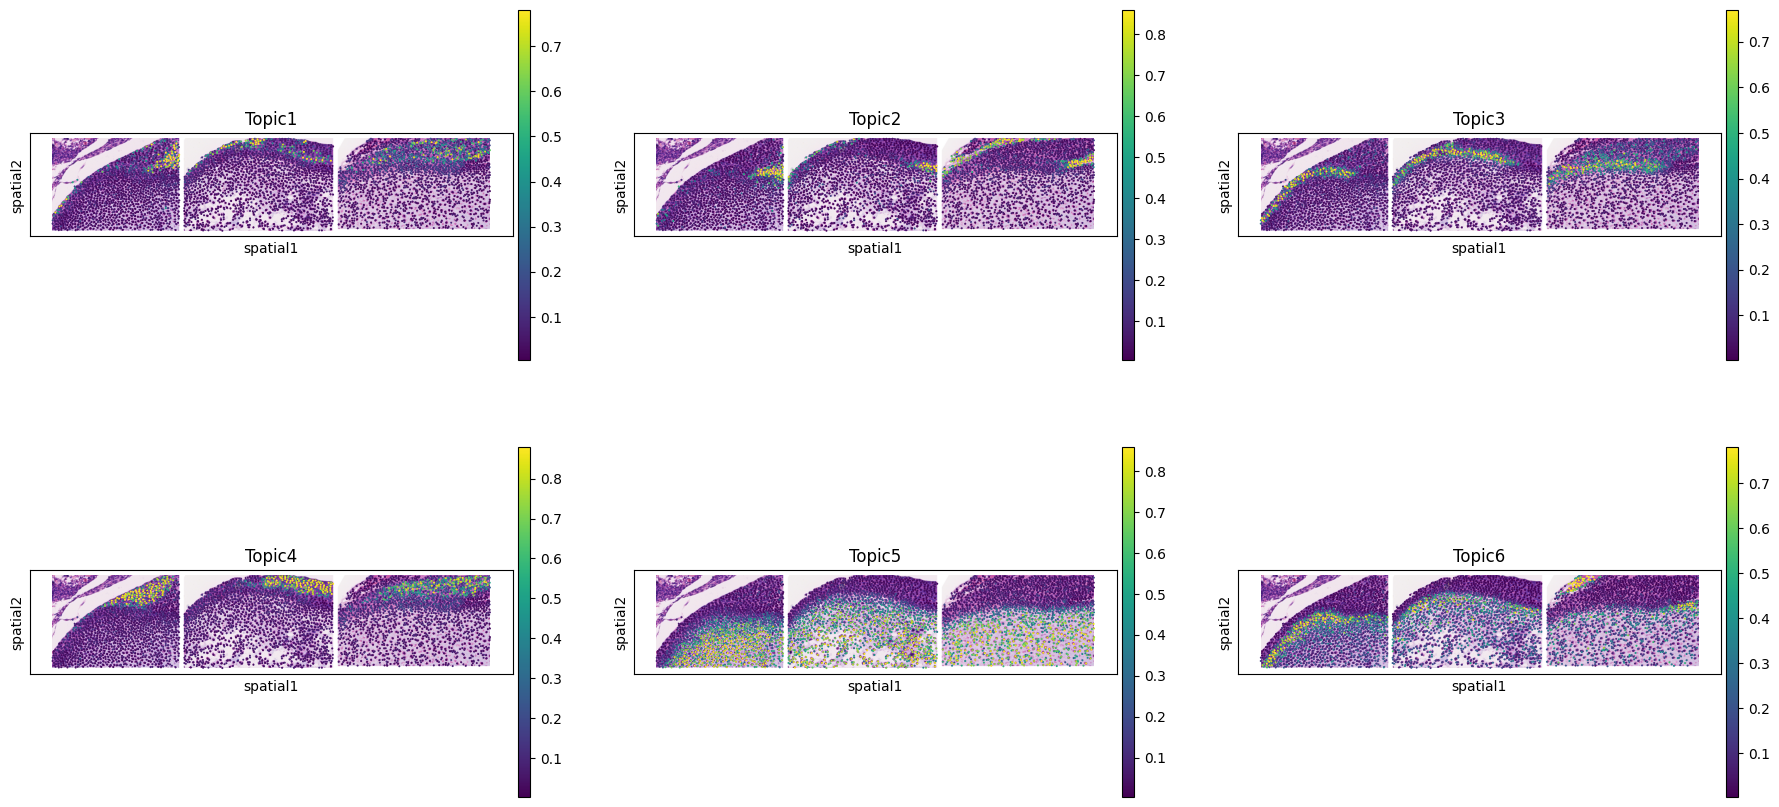

In [22]:
sc.pl.spatial(adata, 
              color=topic_prop.columns, 
              size = 1.2, 
              vmax="p99",
              ncols=3,
              # figsize=(10, 5),
              save = 'topics.pdf')

In [ ]:
topics = ["Topic1", "Topic2","Topic3"]
fig = sctm.pl.plot_spatial(
    adata,
    topic_prop.loc[:, topics],
    spot_size=7,
    figsize=(10, 5),
    display_zeros=False,
    axis_y_flipped=False,
    #save = './scTM/all_topics.pdf'
)

Figure saved to ./scTM/topic_3_hvgs.pdf


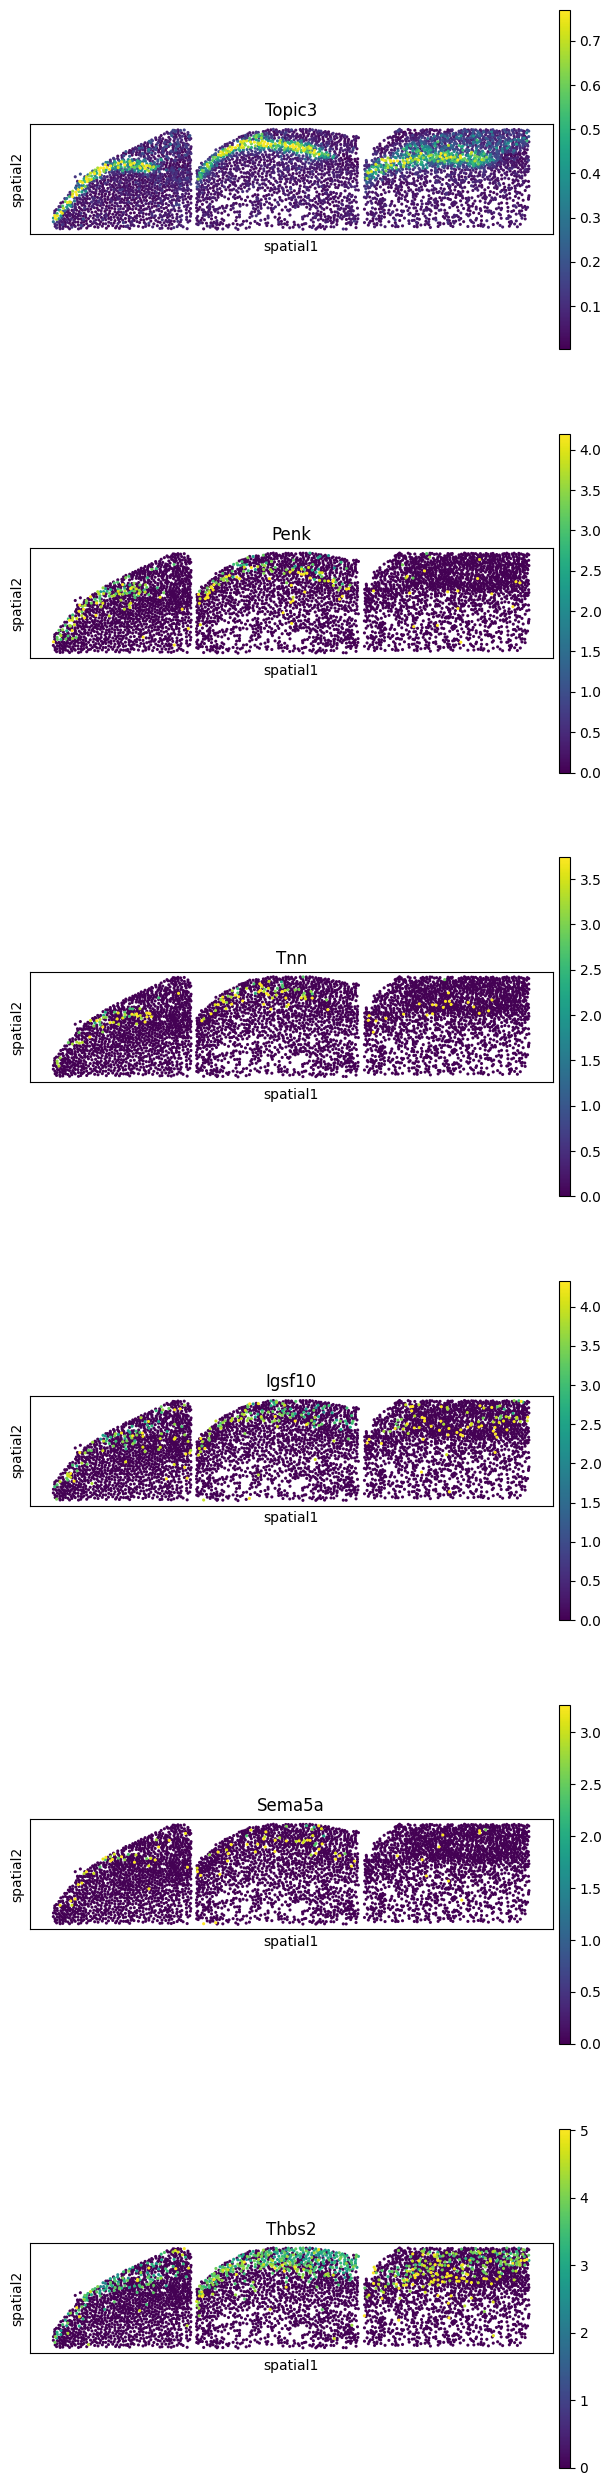

In [43]:
beta_transposed = beta.T
colors_to_plot = ["Topic3"] + beta_transposed.nlargest(5, (0, 'Topic3')).index.tolist()

# Assign to 'axes_list' as it's expected to be a list of Axes
axes_list = sctm.pl.spatial(adata,
                           color=colors_to_plot,
                           ncols=1,
                           size=20,
                           palette='coolwarm',
                            
                           vmax='p99',
                           show=False) # This should make it return Axes

pdf_filename = './scTM/topic_3_hvgs.pdf'

if isinstance(axes_list, list) and len(axes_list) > 0:
    # Get the parent Figure from the first Axes object
    figure_to_save = axes_list[0].figure # .figure is a direct attribute, .get_figure() is a method
    figure_to_save.savefig(pdf_filename, format='pdf', bbox_inches='tight', dpi=300)
    print(f"Figure saved to {pdf_filename}")
elif axes_list is None:
    print("Error: Plotting function returned None. Check 'show=False' or similar parameters.")
else:
    print(f"Error: Expected a list of Axes, but got {type(axes_list)}. Cannot save.")

In [28]:
beta_transposed = beta.T
beta_transposed.nlargest(100, (0, 'Topic3'))

0                                                           1  \
           Topic1    Topic2    Topic3    Topic4    Topic5    Topic6    Topic1   
Penk    -0.866575 -0.377612  1.343680 -0.964405 -1.579442 -0.125561 -0.980056   
Tnn     -0.822346 -0.593675  1.302539 -1.412494 -1.804695 -0.323036 -0.956855   
Igsf10  -0.032881 -0.149978  1.039864 -0.130976 -1.464668 -0.576255  0.158172   
Sema5a  -0.451583 -0.411661  1.031474 -0.307990 -1.284916 -0.397425 -0.719925   
Thbs2    0.036964 -0.577658  1.019774  0.352962 -2.078681 -1.445526 -0.029461   
...           ...       ...       ...       ...       ...       ...       ...   
Tead2   -0.070746 -0.193210  0.493677  0.365769 -1.098711 -0.101947 -0.082769   
Cyfip2   0.039907 -0.654866  0.493467  0.386111 -1.397362 -0.181554  0.275846   
Pcolce  -0.166778  0.034305  0.492955 -0.148989 -0.548985 -0.004111 -0.196142   
App     -0.272947 -0.196819  0.492366 -0.402642 -0.002050  0.118058 -0.232007   
Emilin3  0.005597 -0.460716  0.490000  0.351086 -0.815836 -0.823822 -0.091294   

                                                                  2            \
           Topic2    Topic3    Topic4    Topic5    Topic6    Topic1    Topic2   
Penk    -0.175490  1.286931 -1.513461 -1.617190  0.053462 -1.059638 -0.250862   
Tnn     -0.945026  1.534603 -1.886110 -2.004550 -0.595210 -1.013128 -1.073840   
Igsf10  -0.368615  1.378849 -0.372683 -1.797041 -0.841676  0.216920 -0.450662   
Sema5a  -0.356437  1.102731 -0.477988 -1.114385 -0.089618 -0.850082 -0.647122   
Thbs2   -0.540218  1.283270  0.431826 -2.565407 -1.744564 -0.101660 -0.481555   
...           ...       ...       ...       ...       ...       ...       ...   
Tead2   -0.092009  0.521409  0.271977 -1.097365 -0.180944  0.031818  0.000289   
Cyfip2  -0.897432  0.774562  0.521634 -1.720143 -0.520149  0.366461 -1.039387   
Pcolce   0.185832  0.688606  0.099074 -1.294361 -0.389121  0.066035  0.053630   
App     -0.325865  0.563988 -0.445856  0.048150  0.117312 -0.209669 -0.363831   
Emilin3 -0.601806  0.706246  0.528766 -1.089689 -0.958587 -0.197324 -0.460653   

                                                 
           Topic3    Topic4    Topic5    Topic6  
Penk     0.496399 -1.528139 -1.201526  0.396459  
Tnn      1.318755 -1.823382 -1.699469 -0.814229  
Igsf10   1.246940 -0.326706 -1.629313 -0.897849  
Sema5a   0.627979 -0.489930 -0.849518 -0.130488  
Thbs2    1.056335  0.526939 -2.377225 -1.683350  
...           ...       ...       ...       ...  
Tead2    0.306865  0.159583 -0.992573 -0.420473  
Cyfip2   0.747022  0.449455 -1.613106 -0.770095  
Pcolce   0.789487  0.332620 -1.702188 -1.136933  
App      0.573555 -0.170313  0.081551 -0.143334  
Emilin3  0.889899  0.160091 -1.004166 -0.746741  

[100 rows x 18 columns]

In [ ]:
sctm.pl.heatmap(adata, topic_prop, groupby, dendrogram=False, swap_axes=True, cmap=None, figsize=(10, 5), save=None, **kwargs)

Loaded data bundle from pickle file.
Extracted topic_prop, beta, and adata from bundle.


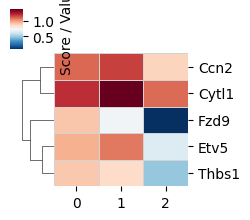

In [62]:
import pickle
import seaborn as sns

# Remember the security warning about unpickling any file!
try:
    with open('./scTM/stamp_analysis_bundle.pkl', 'rb') as f:
        loaded_data_bundle = pickle.load(f)
    print("Loaded data bundle from pickle file.")

    # Extract the individual objects
    beta = loaded_data_bundle['beta']

    print("Extracted topic_prop, beta, and adata from bundle.")

except FileNotFoundError:
    print("Data bundle pickle file not found.")
except Exception as e:
    print(f"An error occurred loading or extracting the bundle: {e}")
    

topic = "Topic6"
genes = []
for i in range(8):
    genes += beta_transposed.nlargest(5, (0, 'Topic6')).index.tolist()
genes = np.unique(genes)

beta.xs(topic, level=1).rank(ascending=False, axis=1).transpose().loc[genes]

g = sns.clustermap(
    beta.xs(topic, level=1).transpose().loc[genes], # Your data selection logic
    col_cluster=False,
    row_cluster=True,
    cmap="RdBu_r",
    #vmin=0,
    #vmax=2,                  # Set maximum value symmetrically
    #center=1,                # Center the colormap at 1
    figsize=(2.5, 2.2),        # Adjust figure size (width, height)
    linewidths=0.5,          # Add subtle lines between cells
    linecolor='lightgrey',   # Color for cell lines
    # standard_scale=0,      # Optional: Uncomment to standardize rows (genes) -> Z-scores
    cbar_kws={'label': 'Score / Value'}, # Add label to the color bar
    xticklabels=True,
    yticklabels=True,
    annot=False
    # save = './scTM/1.tiff'  # This is NOT a valid parameter for clustermap
)

# 2. Define the output filename
pdf_filename = './scTM/topic_6_gene_heatmap.pdf'

# 3. Call the savefig method on the ClusterGrid object
#    Use bbox_inches='tight' to prevent labels/titles from being cut off
g.savefig(pdf_filename, format='pdf', bbox_inches='tight', dpi=300)

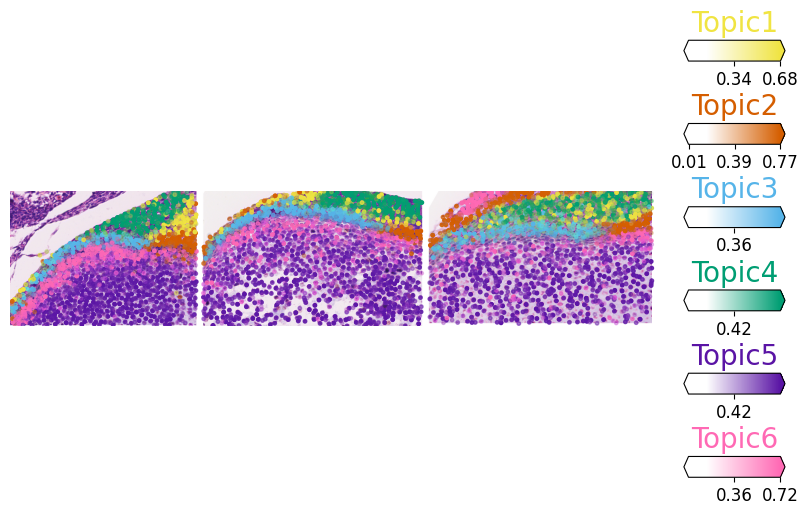

In [32]:
topics = ["Topic1", "Topic2", "Topic3", "Topic4", "Topic5", "Topic6"]
fig = sctm.pl.plot_spatial(
    adata,
    topic_prop.loc[:, topics],
    spot_size=10,
    display_zeros=True,
    axis_y_flipped=False
)

pdf_filename = './scTM/topics_spatial.pdf'
#    Use bbox_inches='tight' to prevent labels/titles from being cut off
fig.savefig(pdf_filename, format='pdf', bbox_inches='tight', dpi=300)

In [ ]:
def get_top_genes(beta, topics, k=1):
    genes = []
    for topic in topics:
        genes += beta.nlargest(k, topic).index.tolist()
    return genes

genes = get_top_genes(beta, topic_prop.columns)
genes

In [39]:
beta_transposed

output_filename = './figures/scTM/beta_transposed_output.tsv'

# Save the DataFrame to a TSV file
# sep='\t' specifies tab separation
# index=True includes the gene names (index) in the file (usually desired)
# header=True includes the column headers (the MultiIndex in this case)
beta_transposed.to_csv(output_filename, sep='\t', index=True, header=True)

print(f"DataFrame successfully saved to '{output_filename}'")

DataFrame successfully saved to './figures/scTM/beta_transposed_output.tsv'


In [40]:
celltypes = sctm.analysis.get_topic_disco(beta, ncores=10)

Process LokyProcess-47:
Traceback (most recent call last):
  File "/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/urllib3/connection.py", line 199, in _new_conn
    sock = connection.create_connection(
  File "/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/home/whc/miniconda3/envs/sctm/lib/python3.8/site-packages/urllib3/connectionpool.py", line 490, in _make_request
    raise new_e
  File "/home/whc/miniconda3/envs/sctm/lib/python3.8/site

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1)}

In [ ]:
celltypes

In [ ]:
filtered = [] 
for i in celltypes.keys():
    # Filter out the low overlap
    df = celltypes[i].loc[celltypes[i].overlap > 5]
    # Filter only in lung
    df = df.loc[df['name'].str.contains("lung")]
    df["Topic"] = i
    filtered.append(df.head(3))